In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 5x: raw/flip/rotate/jitter/blur
# ResNet & VGG
CFG={'SEED' : 42,
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율 (0.1 or 0.2)
     'MODEL_COMBINATION' : 3,  # 1: Res+VGG, 2: VGG+Inception, 3: Res+Inception
     'CONTROL' : "NORMAL",  # "NORMAL" or "NON_SJS"
     'gland' : "PTG_",  # "PTG_" or "SMG_"
     'BATCH_SIZE' : 64,
     'LR' : 1e-4}

In [5]:
control = CFG["CONTROL"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["gland"] == "PTG_":
    gland = "PG"
else:
    gland = "SG"

if CFG["MODEL_COMBINATION"] == 1:
    model1_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Res)_ver2.pt"
    model2_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_VGG)_ver2.pt"
elif CFG["MODEL_COMBINATION"] == 2:
    model1_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Inception)_ver2.pt"
    model2_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_VGG)_ver2.pt"
elif CFG["MODEL_COMBINATION"] == 3:
    model1_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Res)_ver2.pt"
    model2_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_Inception)_ver2.pt"

In [6]:
model1_save_path  # 돌리기 전에 save_path 제대로 불러왔는지 확인하기

"/home/user1/바탕화면/HJ/Sjogren's Syndrome/NORMAL_save_path/NORMAL_5x_test50(PG_Res)_ver2.pt"

In [7]:
model2_save_path  # 돌리기 전에 save_path 제대로 불러왔는지 확인하기

"/home/user1/바탕화면/HJ/Sjogren's Syndrome/NORMAL_save_path/NORMAL_5x_test50(PG_Inception)_ver2.pt"

In [8]:
# 파일 경로 가져오기
# PG: Parotid Gland (귀밑샘)
# SG: Submandibular Gland (턱밑샘)
def GET_PATH(path, control_group, gland):
    # Control group: "NORMAL" or "NON_SJS" (문자열 입력)
    # Gland: "PTG_" or "SMG_" (문자열 입력)
    control_list, sjs_list = [], []
    control_label, sjs_label = [], []
    for diagnosis in os.listdir(path):
        if diagnosis == control_group:    # CONTROL: NORMAL / NON_SJS
            control_path = path + diagnosis + f"/"
            for control_img in os.listdir(control_path):
                control_img_path = control_path + control_img
                if gland in control_img:
                    control_list.append(control_img_path)
                    control_label.append(np.array([0,1]))
        elif diagnosis == 'SJS':
            sjs_path = path + diagnosis + f"/"
            for sjs_img in os.listdir(sjs_path):
                sjs_img_path = sjs_path + sjs_img
                if gland in sjs_img:
                    sjs_list.append(sjs_img_path)
                    sjs_label.append(np.array([1,0]))
    
    return control_list, sjs_list, control_label, sjs_label

In [9]:
# Total_Data -> PG / SG -> NORMAL / SJS
root_path = f"/home/user1/Documents/Project2/AICOSS/Total_Data/"
control_path, sjs_path, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"], CFG["gland"])

In [10]:
total_path = control_path + sjs_path
total_label = control_label + sjs_label

print(f"TOTAL: {len(total_path)}")
print(f"CONTROL: {len(control_path)}")
print(f"SJS: {len(sjs_path)}")

TOTAL: 3260
CONTROL: 1030
SJS: 2230


In [11]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img__(self, path):
        img = PIL.Image.open(path)
        return img
    
    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img__(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [12]:
test_control_length = int(CFG['TEST_PORTION']*len(control_path))
test_control_indexes = random.sample(range(0,len(control_path)), test_control_length)
train_control_indexes = list(set(list(range(0,len(control_path))))-set(test_control_indexes))

test_sjs_length = int(CFG['TEST_PORTION']*len(sjs_path))
test_sjs_indexes = random.sample(range(0,len(sjs_path)), test_sjs_length)
train_sjs_indexes = list(set(list(range(0,len(sjs_path))))-set(test_sjs_indexes))

test_path = list(map(lambda x: control_path[x], test_control_indexes)) + list(map(lambda x: sjs_path[x], test_sjs_indexes))
test_label = list(map(lambda x: control_label[x], test_control_indexes)) + list(map(lambda x: sjs_label[x], test_sjs_indexes))
train_path = list(map(lambda x: control_path[x], train_control_indexes)) + list(map(lambda x: sjs_path[x], train_sjs_indexes))
train_label = list(map(lambda x: control_label[x], train_control_indexes)) + list(map(lambda x: sjs_label[x], train_sjs_indexes))

print(f"PLAIN TRAIN: {len(train_path)}")
print(f"PLAIN TEST: {len(test_path)}")
print(f"TOTAL: {len(train_path)+len(test_path)} == {len(total_path)}")
print()

test_dataset = CustomDataset(test_path, test_label, transform=preprocessing)

print(f"Train CONTROL indexes: {train_control_indexes[:5]}")
print(f"Test CONTROL indexes: {test_control_indexes[:5]}")
print(f"Train SJS indexes: {train_sjs_indexes[:5]}")
print(f"Test SJS indexes: {test_sjs_indexes[:5]}")
print(f"TEST: {len(test_dataset)}")

PLAIN TRAIN: 1630
PLAIN TEST: 1630
TOTAL: 3260 == 3260

Train CONTROL indexes: [1, 4, 5, 10, 12]
Test CONTROL indexes: [228, 51, 563, 501, 457]
Train SJS indexes: [0, 2048, 2050, 3, 4]
Test SJS indexes: [1087, 156, 444, 1779, 1415]
TEST: 1630


In [13]:
import timm

class Model1(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        if CFG["MODEL_COMBINATION"] == 1 or CFG["MODEL_COMBINATION"] == 3: # 1: Res+VGG, 3: Res+Inception
            self.model = timm.create_model('resnet50', pretrained=True)
        elif CFG["MODEL_COMBINATION"] == 2: # Inception+VGG
            self.model = timm.create_model('inception_v3', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

class Model2(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        if CFG["MODEL_COMBINATION"] == 1 or CFG["MODEL_COMBINATION"] == 2: # 1: Res+VGG, 2: Inception+VGG
            self.model = timm.create_model('vgg16_bn', pretrained=True)
            self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
        elif CFG["MODEL_COMBINATION"] == 3: # Res+Inception
            self.model = timm.create_model('inception_v3', pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [14]:
model1 = Model1().to(device)
model2 = Model2().to(device)

In [15]:
def test_loop(dataloader, model1, model2, model1_path, model2_path):
    model1.load_state_dict(torch.load(model1_path))
    model2.load_state_dict(torch.load(model2_path))
    model1.eval()
    model2.eval()

    pred_control=[]
    label_control=[]
    pred_sjs=[]
    label_sjs=[]

    pred=[]
    label=[]

    for (X, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_control.append(t[1].detach().tolist())
            label_sjs.append(t[0].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output1 = model1(X)
        output2 = model2(X)
        output = 0.5*output1 + 0.5*output2

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_control.append(o[1].detach().cpu().tolist())
            pred_sjs.append(o[0].detach().cpu().tolist())

    return label_control, label_sjs, pred_control, pred_sjs, np.array(label), np.array(pred)

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
label_control, label_sjs, pred_control, pred_sjs, label, pred = test_loop(test_dataloader, model1, model2, model1_save_path, model2_save_path)

In [17]:
test_control, test_sjs = 0, 0
for (X, y) in test_dataloader:
    for t in y:
        if t[1] == torch.Tensor([1]):
            test_control += 1
        else:
            test_sjs += 1

print(test_control)
print(test_sjs)

515
1115


0.8325577974319458


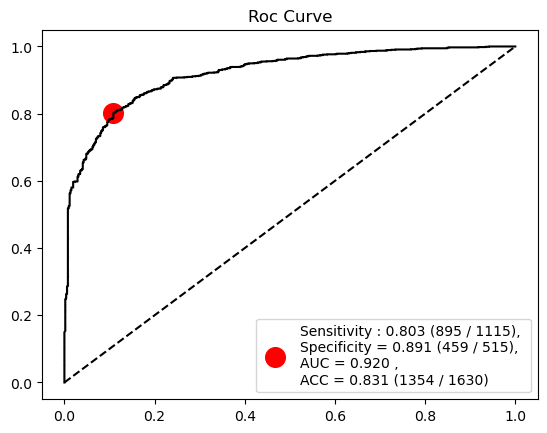

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(label_sjs, pred_sjs)

fpr, tpr, thresholds = roc_curve(label_sjs, pred_sjs)
J=tpr-fpr
idx = np.argmax(J)

best_thresh = thresholds[idx]
sens, spec = tpr[idx], 1-fpr[idx]
print(best_thresh)

acc = (sens*test_sjs + spec*test_control) / len(label_sjs)
auc = roc_auc_score(label_sjs, pred_sjs)

plt.title("Roc Curve")
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05)
plt.scatter(fpr[idx], tpr[idx], marker='o', s=200, color='r',
            label = 'Sensitivity : %.3f (%d / %d), \nSpecificity = %.3f (%d / %d), \nAUC = %.3f , \nACC = %.3f (%d / %d)' % (sens, (sens*test_sjs), test_sjs, spec, (spec*test_control), test_control, auc, acc, sens*test_sjs+spec*test_control, test_sjs+test_control))
plt.legend()

<Axes: >

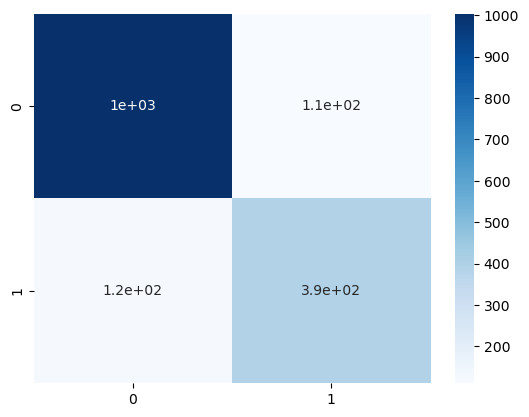

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')